# 04. PyTorch custom datasets

Depending on whether we're working on text, audio, vision, recommendation, etc., we will want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions

## 0. Importing PyTorch and setting up device-agnostic code

In [5]:
import torch
from torch import nn

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

The dataset is a subset of the Food101 dataset.

It starts with 101 diff. classes of food and 1000 images per class (750 training, 250 testing)

The dataset used here has 3 classes of food and 10% of the images

Important to try things on a small scale and increase it when necessary.

Whole point is to speed up how fast we can experiment.

In [7]:
import requests
import zipfile
from pathlib import Path

data_path = Path('data')
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} already exists! Skipping download.")
else:
    print(f"{image_path} does not exist")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", mode="wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza, steak, sushi data")
    f.write(request.content)

# Unzip the data

with zipfile.ZipFile(file=data_path / "pizza_steak_sushi.zip", mode="r") as zip_ref:
    print("Unzipping pizza, steak, sushi data")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi already exists! Skipping download.
Unzipping pizza, steak, sushi data


## 2. Data preparation and exploration

In [8]:
import os

def walk_through_dir(dir_path):
    '''Walks through dir path, returning contents'''
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories, {len(filenames)} files in {dirpath}.")

In [9]:
walk_through_dir(image_path)

There are 2 directories, 0 files in data\pizza_steak_sushi.
There are 3 directories, 0 files in data\pizza_steak_sushi\test.
There are 0 directories, 25 files in data\pizza_steak_sushi\test\pizza.
There are 0 directories, 19 files in data\pizza_steak_sushi\test\steak.
There are 0 directories, 31 files in data\pizza_steak_sushi\test\sushi.
There are 3 directories, 0 files in data\pizza_steak_sushi\train.
There are 0 directories, 78 files in data\pizza_steak_sushi\train\pizza.
There are 0 directories, 75 files in data\pizza_steak_sushi\train\steak.
There are 0 directories, 72 files in data\pizza_steak_sushi\train\sushi.


In [10]:
# Set up train and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

1. Get all image paths
2. Pick an image randomly using Python's `random.choice()`
3. Get the image class name
4. Get the image class name using `pathlib.Path.parent.stem`
5. Since we are working with images, open the image with Python PIL (Python Image Library) -> actually use `Pillow`, a PIL fork
6. Show image and print metadata

data\pizza_steak_sushi\test\sushi\2394442.jpg
data\pizza_steak_sushi\test\sushi
sushi
Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Random image class: sushi
Random image dims: 408 x 512


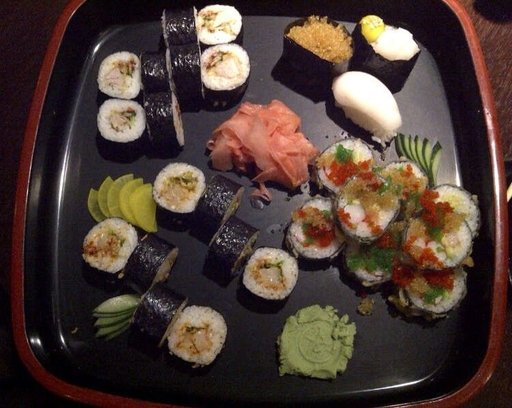

In [11]:
import random
from PIL import Image

random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
random_image_class = random_image_path.parent.stem
print(random_image_path.parent)
print(random_image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Random image class: {random_image_class}")
print(f"Random image dims: {img.height} x {img.width}")
img

Text(0.5, 1.0, 'sushi')

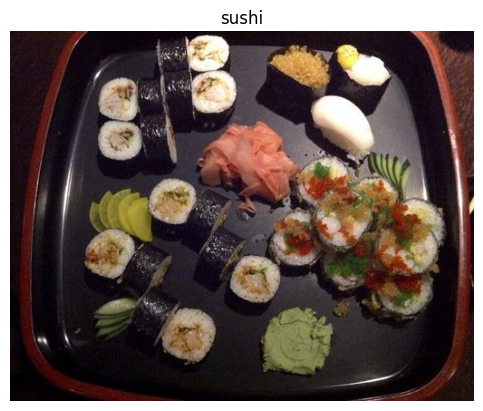

In [12]:
# Visualize  with matplotlib

import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis(False)
plt.title(random_image_class)

In [13]:
import numpy as np
img_as_array = np.asarray(img)

img_as_array.shape

(408, 512, 3)

## 3. Transforming data

Need to convert data into Tensors before using with PyTorch

Also convert it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [14]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [15]:
data_transform = transforms.Compose([
    # Resize to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images (data augmentation) randomly on the horizontal
     transforms.RandomHorizontalFlip(p=0.5),
     # Turn image into a torch.Tensor
     transforms.ToTensor()
])

In [16]:
data_transform(img).shape

torch.Size([3, 64, 64])

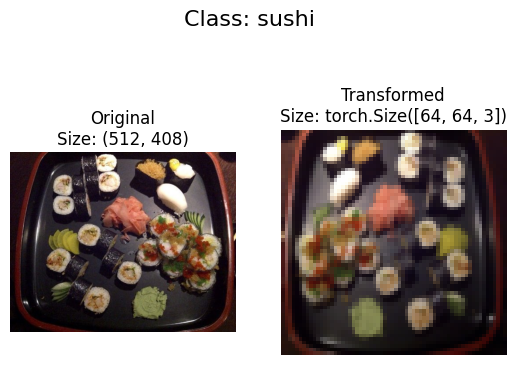

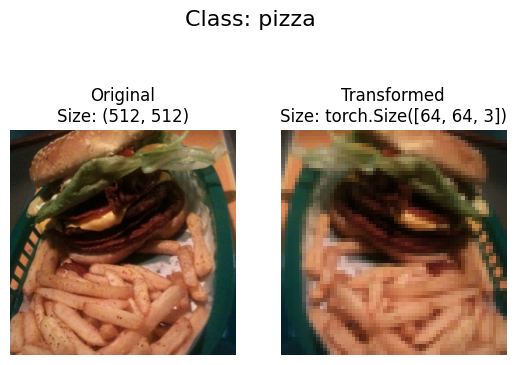

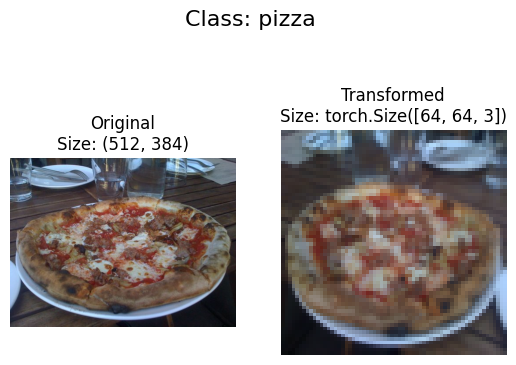

In [17]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    '''Select random images from a path of random images and loads/transforms them, then plots original vs transformed'''
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f)
            transformed_image = torch.permute(transformed_image, (1, 2, 0))
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)


## 4. Option 1: Loading image data using `ImageFolder`

Can load img classification data using `torchvision.datasets.ImageFolder`

In [18]:
# Use ImageFolder to create datasets
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [19]:
# Get classnames as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [20]:
# Get classnames as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [21]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [22]:
# Index on train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape:\n{img.shape}")
print(f"Image datatype:\n{img.dtype}")
print(f"Label:\n{label}")
print(f"Label datatype:\n{type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

In [23]:
class_names[label]

'pizza'

In [24]:
# Rearrange the oder dimensions
img_permute = img.permute(1, 2, 0)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

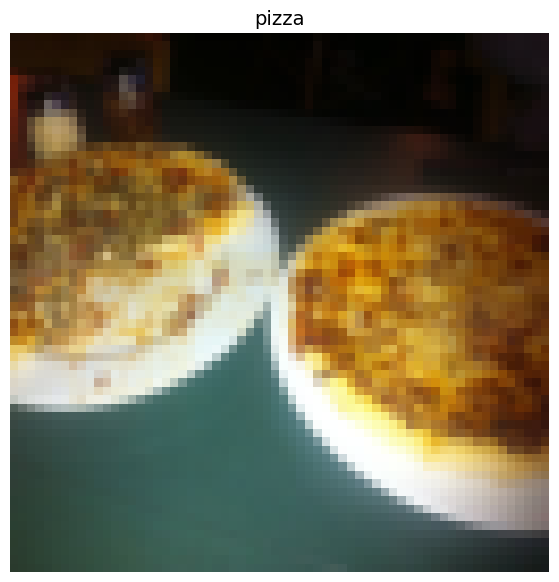

In [25]:
# Plot fig
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.title(class_names[label], fontsize=14)
plt.axis(False)

### 4.1 Turn loaded images into `DataLoaders`

In [26]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data, batch_size=1, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=False, num_workers=os.cpu_count())

train_dataloader

In [27]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [28]:
img, label = next(iter(train_dataloader))
img.shape, label

(torch.Size([1, 3, 64, 64]), tensor([1]))

## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Load images from file
2. Get classnames from Dataset
3. Get classes as dict from Dataset

Pros:
* Can create Dataset from almost anything
* Not limited to PyTorch prebuilt Dataset functions

Cons:
* Does not mean it will work
* Using a custom Dataset results in us writing more code, which could be prone to errors or performance issues


All custom datasets in PyTorch often subclass `torch.utils.data.Dataset` 

In [29]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [30]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating helper function to get classnames

1. Use `os.scandir()` to traverse a target directory and get classnames (ideally it is in standard image classification format)
2. Raise an error if classnames are not found
3. Turn the classnames into a dict and a list, and return them

In [31]:
# Set up path for target dir

target_directory = train_dir
print(f"Target dir: {target_directory}")

# get classnames from target dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [32]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    '''Finds class folder names in a target directory.'''
    # get classnames from target dir
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}")

    # create a directory of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)} 
    return classes, class_to_idx

In [33]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`
2. Init subclass with target directory as well as transform it (if needed)
3. Create attributes:
   1. paths
   2. transform
   3. classes
   4. class_to_idx
4. Create func `load_images()`
5. Overwrite the `__len()__` method to return length
6. Overwrite `__getitem()__` to return sample when passed an index

In [34]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. subclass Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize custom dataset
    def __init__(self, targ_dir: str, transform=None):
        # 3. Create class attr
        # Get all img paths
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
        # Setup transform
        self.transform = transform
        # Create classes and class_to_idx attr
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a func to load images
    def load_image(self, index: int) -> Image.Image:
        '''Opens an image via a path and returns it.'''
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        '''Returns total number of samples.'''
        return len(self.paths)
    
    # 6. Overwrite __getitem__()
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        '''Returns one sample of data, data and label (X, y).'''
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format data_folder/class_name/image/jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [35]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [36]:
# Test ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)

In [37]:
train_data_custom

In [38]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [39]:
len(train_data), len(train_data_custom)

(225, 225)

In [40]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [42]:
# Check for equality b/w ImageFolder and ImageFolderCustom
print(train_data.classes == train_data_custom.classes)
print(test_data.classes == test_data_custom.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and number of other params such as class names and how many images to visualize
2. To prevent the display getting out of hand, cap number of images to 10
3. Set random seed
4. Get list of random sample indexes from target dataset
5. Set up matplotlib plot
6. Loop through the sample images and plot them
7. Make sure dims of images line up with matplotlib

In [43]:
# 1. Create func
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust dispplay if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"n should be <= 10. Setting n = 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Set up plot
    plt.figure(figsize=(16, 8))

    # 6. Loop thru random indexes & plot them
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dims for plotting
        targ_image_adjusted = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjusted)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\nShape: {targ_image_adjusted.shape}"
        plt.title(title)

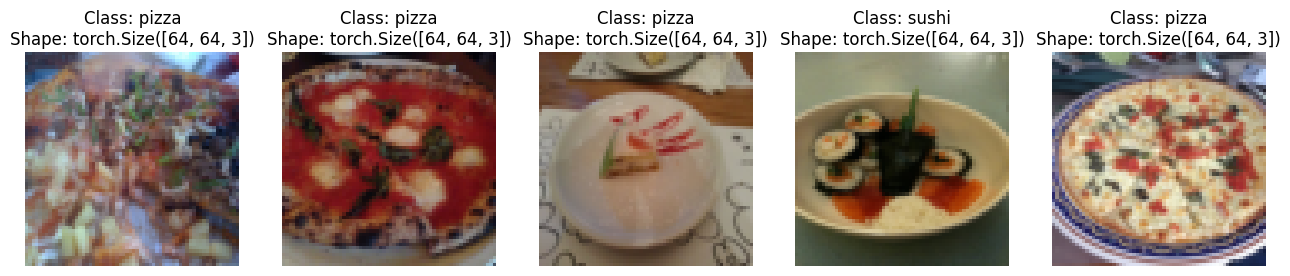

In [44]:
display_random_images(train_data, train_data.classes, 5, True, None)

n should be <= 10. Setting n = 10 and removing shape display.


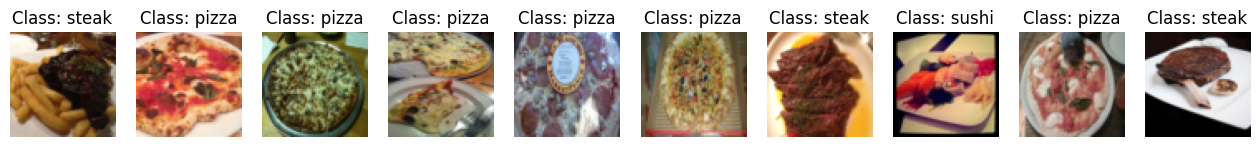

In [46]:
display_random_images(train_data_custom, train_data.classes, 11, True, None)